# Итоговый проект: Определение фейковых новостей

### Автор: Бородин Святослав Михайлович
### Репозиторий Github: https://github.com/GrosBoy/Project-Fake-n-Real-News
### Датасет: https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset
### Разработать автоматизированную систему или алгоритм, способный с высокой точностью отличать достоверную информацию от преднамеренно ложной, вводящей в заблуждение или непроверенной (фейковой) в текстовом контенте, маскирующемся под новости.

## 2. Постановка задачи

- Предсказать классификацию новостей
- Важна эта задача по той причине, что в настоящее время мы не можем точно понимать, настоящая ли новость или нет.
- Доступна вся информация из Средства Массовой Информации.
- Будет использоваться метрики Accuracy, Precision, Recall и F1-мера.
- Будем использовать Confusion Matrix для определения результата

### Подключаем библиотеки

In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

В этом разделе данные загружены и проверены на корректность:

- размер датасета  
- типы переменных  
- пропуски  
- первые строки  

# Скачиваем алфавит и символы пунктуации

In [ ]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
lemm = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z ]', '', text) # только буквы и пробелы
    tokens = nltk.word_tokenize(text)
    tokens = [lemm.lemmatize(w) for w in tokens if w not in stop_words]
    return ' '.join(tokens)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


#Подключаем датасет

In [3]:
import kagglehub
import pandas as pd
import os

# Download latest version
path = kagglehub.dataset_download("clmentbisaillon/fake-and-real-news-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'fake-and-real-news-dataset' dataset.
Path to dataset files: /kaggle/input/fake-and-real-news-dataset


#Добавляем таблицы с правдивыми и лживыми новостями и соединяем их в одну, добавляем индекс правдивости и убираем лишние символы


In [4]:
DATA_DIR = os.path.join("Project-Fake-n-Real-News\data", "")

print("Dataset folder:", DATA_DIR)
print(os.listdir(DATA_DIR))

Dataset folder: Project-Fake-n-Real-News\data/


<>:1: SyntaxWarning: invalid escape sequence '\d'
<>:1: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipython-input-3902809032.py:1: SyntaxWarning: invalid escape sequence '\d'
  DATA_DIR = os.path.join("Project-Fake-n-Real-News\data", "")


FileNotFoundError: [Errno 2] No such file or directory: 'Project-Fake-n-Real-News\\data/'

In [ ]:
true_path=os.path.join(DATA_DIR,'True.csv')
true = pd.read_csv(true_path)

true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [ ]:
fake_path=os.path.join(DATA_DIR,'Fake.csv')
fake = pd.read_csv(fake_path)
true['label'] = 0
fake['label'] = 1
data = pd.concat([true, fake], ignore_index=True)

data = data.sample(5000, random_state=42)
data['clean'] = data['title'].apply(clean_text) + data['text'].apply(clean_text)
data.head(10)

,title,text,subject,date,label,clean
22216,BREAKING: GOP Chairman Grassley Has Had Enoug...,"Donald Trump s White House is in chaos, and th...",News,"July 21, 2017",1,breaking gop chairman grassley enough demand t...
27917,Failed GOP Candidates Remembered In Hilarious...,Now that Donald Trump is the presumptive GOP n...,News,"May 7, 2016",1,failed gop candidate remembered hilarious mock...
25007,Mike Pence’s New DC Neighbors Are HILARIOUSLY...,Mike Pence is a huge homophobe. He supports ex...,News,"December 3, 2016",1,mike pences new dc neighbor hilariously trolli...
1377,California AG pledges to defend birth control ...,SAN FRANCISCO (Reuters) - California Attorney ...,politicsNews,"October 6, 2017",0,california ag pledge defend birth control insu...
32476,AZ RANCHERS Living On US-Mexico Border Destroy...,Twisted reasoning is all that comes from Pelos...,politics,"Apr 25, 2017",1,az rancher living usmexico border destroy nanc...
5766,"As private lawyer, Trump high court pick was f...",WASHINGTON (Reuters) - As a lawyer in private ...,politicsNews,"February 1, 2017",0,private lawyer trump high court pick friend bu...
16230,Yemeni Salafist imam killed in Aden: sources,ADEN (Reuters) - A Salafist imam was shot dead...,worldnews,"October 28, 2017",0,yemeni salafist imam killed aden sourceaden re...
20911,FBI says witnesses in U.S. probe into Malaysia...,KUALA LUMPUR (Reuters) - Potential witnesses t...,worldnews,"September 6, 2017",0,fbi say witness u probe malaysia mdb fear safe...
35838,An Easy To Read Chart Shows How Bernie Sanders...,The goal of socialism is communism. -Vladimi...,politics,"Feb 24, 2016",1,easy read chart show bernie sander socialism s...
33155,MMA FIGHTER JAKE SHIELDS Embarrasses Cowards I...,Opposing views and beliefs has much of this co...,politics,"Feb 4, 2017",1,mma fighter jake shield embarrasses coward mas...


## Выводы:
- количество строк и столбцов  
- явные проблемы данных  
- какие признаки требуют внимания  

### Векторизируем каждое слово

In [ ]:
bow = CountVectorizer()
X_bow = bow.fit_transform(data['clean'])
y = data['label']

In [ ]:
print("Размерность:", X_bow.shape)

Размерность: (5000, 63329)


In [ ]:
bow_df = pd.DataFrame(X_bow.toarray(), columns=bow.get_feature_names_out())
bow_df.head(10)

,aa,aaarf,aab,aaba,aabo,aadhaar,aadl,aai,aamom,aaplo,...,zuo,zuoan,zverev,zwak,zweli,zwillich,zwillig,zygote,zynga,zztaine
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
tfidf = TfidfVectorizer()
X_tfidf = tfidf.fit_transform(data['clean'])

In [ ]:
print("Размерность TF-IDF:", X_tfidf.shape)

Размерность TF-IDF: (5000, 63329)


#Создаём слои и запускаем машинное обучение

In [ ]:
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(data['clean'])
X_seq = tokenizer.texts_to_sequences(data['clean'])
X_pad = pad_sequences(X_seq, maxlen=40, padding='post')

X_train, X_test, y_train, y_test = train_test_split(X_pad, y, test_size=0.2, random_state=42)

In [ ]:
model_lstm = Sequential([
    Embedding(10000, 64, input_length=40),
    LSTM(64, return_sequences=False),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_lstm.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model_lstm.fit(
    X_train, y_train,
    epochs=3,
    batch_size=128,
    validation_split=0.2
)

Epoch 1/3
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 1.0000 - loss: 1.7332e-04 - val_accuracy: 0.9075 - val_loss: 0.7240
Epoch 2/3
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - accuracy: 1.0000 - loss: 1.7547e-04 - val_accuracy: 0.9075 - val_loss: 0.7614
Epoch 3/3
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 1.0000 - loss: 1.1973e-04 - val_accuracy: 0.9075 - val_loss: 0.7885


#Смотрим результаты машинного обучения

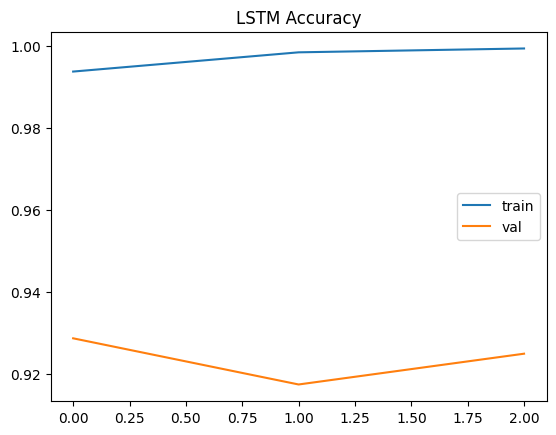

In [ ]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.legend()
plt.title("LSTM Accuracy")
plt.show()

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


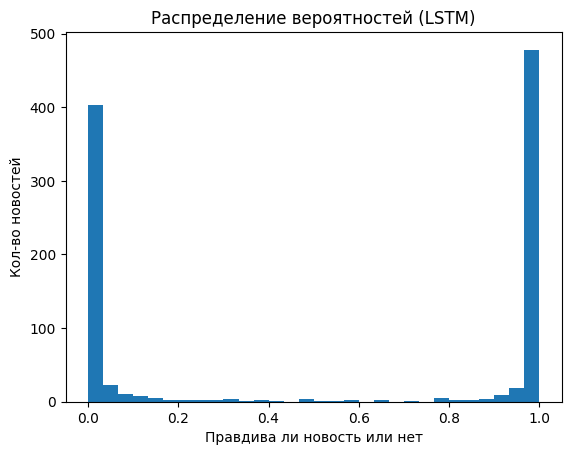

In [ ]:
preds = model_lstm.predict(X_test[:1000])
plt.hist(preds, bins=30)
plt.title("Распределение вероятностей (LSTM)")
plt.xlabel("Правдива ли новость или нет")
plt.ylabel("Кол-во новостей")
plt.show()

In [ ]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [ ]:
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy * 100 :.2f}%")
print(f"Precision: {precision * 100 :.2f}%")
print(f"Recall: {recall * 100 :.2f}%")
print(f"F1-score: {f1 * 100 :.2f}%")

Accuracy: 57.80%
Precision: 59.33%
Recall: 66.23%
F1-score: 62.59%


In [ ]:
print("Classification Report:\n",classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.48      0.52       467
           1       0.59      0.66      0.63       533

    accuracy                           0.58      1000
   macro avg       0.57      0.57      0.57      1000
weighted avg       0.58      0.58      0.57      1000



Text(0.5, 1.0, 'Confusion Matrix')

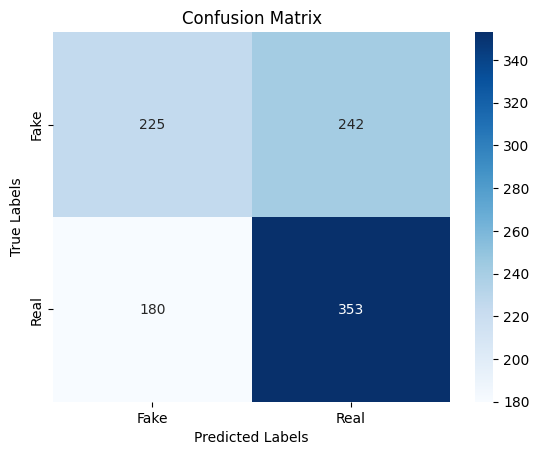

In [ ]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')